# Main Notebook to run the Code in Colab

Open this notebook in Colab, the first few cells will copy the repo from git and make the modules available in the notebook itself.

Import any packages from the GitHub repo (for example from the src directory)
by calling src.package_name

In [31]:
# only clone and run this notebook in colab. The import should fail otherwise
import google.colab
from google.colab import files
import os
import sys

!git clone https://github.com/AveraGE0/MLRFH.git

src_path = os.path.join("MLRFH/")
# Add src folder to sys.path if not already added
if src_path not in sys.path:
    sys.path.append(src_path)

fatal: destination path 'MLRFH' already exists and is not an empty directory.


In [32]:
os.chdir("MLRFH/")
!git pull https://github.com/AveraGE0/MLRFH.git
os.chdir("../")

From https://github.com/AveraGE0/MLRFH
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


In [33]:

PROJECT_ID = "wired-apex-440209-r3" # Replace

In [34]:
import os
from google.colab import auth

DATASET_PROJECT_ID = 'amsterdamumcdb'
DATASET_ID = 'version1_5_0'
LOCATION = 'eu'

os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

auth.authenticate_user()
print('Authenticated')

Authenticated


In [35]:
%load_ext google.colab.data_table
from google.colab.data_table import DataTable

DataTable.max_columns = 30
DataTable.max_rows = 30000

from google.cloud.bigquery import magics
from google.cloud import bigquery

def_config = bigquery.job.QueryJobConfig(default_dataset=DATASET_PROJECT_ID + "." + DATASET_ID)
magics.context.default_query_job_config = def_config

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


config_gbq = {
    'query': {
        'defaultDataset': {
              "datasetId": DATASET_ID,
              "projectId": DATASET_PROJECT_ID
        },
    'Location': LOCATION}
}

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [36]:
#get the amsterdamumcdb package from PyPI repository for use in Colab
!pip install amsterdamumcdb
import amsterdamumcdb as adb

In [ ]:
from src.data_processing.process import process_data


df_train, df_val, df_test = process_data(PROJECT_ID, config_gbq, default_path="./MLRFH")

df_train["pao2"] = (df_train["pao2"] - df_train["pao2"].mean()) / df_train["pao2"].std()
df_train = df_train.reset_index()




Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
INFO: 
Unique septic persons: 1746
Unique septic admissions: 1882
INFO: 
Unique septic shock persons: 1258
Unique septic shock admissions: 1321
Downloading: 100%|██████████|
Unique features being loaded ['Weight' 'Heart Rate' 'Systolic Blood Pressure' 'Mean Blood Pressure'
 'Diastolic blood pressure' 'Respiratory rate' 'SpO2' 'Temperature'
 'Potassium' 'Sodium' 'Chloride' 'Glucose' 'Urea' 'Creatinine' 'Magnesium'
 'Calcium.ionized' 'Calcium' 'paCO2' 'Aspartate aminotransferase'
 'Alanine aminotransferase' 'Bilirubin.total' 'Albumin' 'Hemoglobin'
 'Leukocytes' 'Platelets' 'aPTT' 'PT' 'INR' 'pH Blood' 'PaOxygen'
 'Base excess' 'Bicarbonate' 'Lactate' 'FiO2' 'Urine

# Making the Actions (Space)

## Vasopressors and Ionotropes

In [ ]:
query = f"""
WITH filtered_measurement AS (
    SELECT
        visit_occurrence_id,
        value_as_number AS patientweight
    FROM measurement
    WHERE provider_id IS NULL
    AND measurement_concept_id IN (
        3026600, -- Body weight Estimated
        3013762, -- Body weight Measured
        3023166, -- Body weight Stated
        3025315  -- Body weight
    )
),
dosing AS (
    SELECT
        de.person_id,
        de.visit_occurrence_id,
        de.drug_concept_id AS itemid,
        c.concept_name AS item,
        de.drug_exposure_start_datetime AS start_datetime,
        de.drug_exposure_end_datetime AS stop_datetime,
        TIMESTAMP_DIFF(de.drug_exposure_end_datetime, de.drug_exposure_start_datetime, MINUTE) AS duration,
        -- Extract dose and rate from the sig field
        CAST(REGEXP_EXTRACT(de.sig, r'(\\d+\\.?\\d*) mg') AS FLOAT64) AS dose,
        CAST(REGEXP_EXTRACT(de.sig, r'@ (\\d+\\.?\\d*) mg/uur') AS FLOAT64) AS rate,
        'mg/uur' AS rateunit,
        fm.patientweight
    FROM drug_exposure de
    LEFT JOIN visit_occurrence vo ON de.visit_occurrence_id = vo.visit_occurrence_id
    LEFT JOIN concept c ON de.drug_concept_id = c.concept_id
    LEFT JOIN filtered_measurement fm ON de.visit_occurrence_id = fm.visit_occurrence_id
    WHERE c.concept_id IN (
            36411287, -- 50 ML Dopamine 4 MG/ML Injectable Solution
            21088391, -- 50 ML Dobutamine 5 MG/ML Injection
            19076867, -- Epinephrine 0.1 MG/ML Injectable Solution
            2907531  -- 50 ML Norepinephrine 0.2 MG/ML Injection
        )
    AND de.visit_occurrence_id IN {tuple(df_train.reset_index()["visit_occurrence_id"].tolist())}
    AND CAST(REGEXP_EXTRACT(de.sig, r'@ (\\d+\\.?\\d*) mg/uur') AS FLOAT64) > 0.1
)
SELECT
    person_id,
    visit_occurrence_id,
    itemid,
    item,
    duration,
    dose,
    rate,
    rateunit,
    start_datetime,
    stop_datetime,
    patientweight,
    CASE
        -- recalculate the dose to µg/kg/min ('gamma')
        WHEN rateunit = 'mg/uur' THEN (rate * 1000) / patientweight / 60 -- convert mg/hour to µg/kg/min
        ELSE NULL -- Placeholder for other conversions if necessary
    END AS gamma
FROM dosing
ORDER BY visit_occurrence_id, start_datetime
"""

sepsis_vasopressors = pd.read_gbq(query, configuration=config_gbq, use_bqstorage_api=True)

#print(sepsis_vasopressors.head())
print(f"Etracted {len(sepsis_vasopressors)} records")
print(f"Unique vasopressors {sepsis_vasopressors['item'].unique()}")

sepsis_vasopressors.head()

<ipython-input-8-d33c23db63e0>:63: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  sepsis_vasopressors = pd.read_gbq(query, configuration=config_gbq, use_bqstorage_api=True)


Etracted 44416 records
Unique vasopressors ['50 ML norepinephrine 0.2 MG/ML Injection'
 'epinephrine 0.1 MG/ML Injectable Solution'
 '50 ML Dopamine 4 MG/ML Injectable Solution'
 '50 ML Dobutamine 5 MG/ML Injection']


,person_id,visit_occurrence_id,itemid,item,duration,dose,rate,rateunit,start_datetime,stop_datetime,patientweight,gamma
0,11,11,2907531,50 ML norepinephrine 0.2 MG/ML Injection,75,10.00,8.0,mg/uur,2006-01-01 00:49:00+00:00,2006-01-01 02:04:00+00:00,85.00000000000000000000000000000000000000,1.568627
1,11,11,2907531,50 ML norepinephrine 0.2 MG/ML Injection,75,10.00,8.0,mg/uur,2006-01-01 02:04:00+00:00,2006-01-01 03:19:00+00:00,85.00000000000000000000000000000000000000,1.568627
2,11,11,2907531,50 ML norepinephrine 0.2 MG/ML Injection,75,10.00,8.0,mg/uur,2006-01-01 03:19:00+00:00,2006-01-01 04:34:00+00:00,85.00000000000000000000000000000000000000,1.568627
3,11,11,2907531,50 ML norepinephrine 0.2 MG/ML Injection,56,7.47,8.0,mg/uur,2006-01-01 04:34:00+00:00,2006-01-01 05:30:00+00:00,85.00000000000000000000000000000000000000,1.568627
4,11,11,2907531,50 ML norepinephrine 0.2 MG/ML Injection,15,2.53,10.0,mg/uur,2006-01-01 05:30:00+00:00,2006-01-01 05:45:00+00:00,85.00000000000000000000000000000000000000,1.960784


### Calculating Epinephrine Equivalent Values[[1](https://pmc.ncbi.nlm.nih.gov/articles/PMC3590882/pdf/chest_143_3_664.pdf)] (e-table 2)

| Vasopressor | Norepinephrine Equivalent Dose |
|-|-|
|Epinephrine| 1 |
| Norepinephrin | 1 |
|Dopamin| 0.01|
|Dobutamine**| 0.01 |




** Derived from VIS-score[[1](https://www.sciencedirect.com/science/article/abs/pii/S1053077020310351?fr=RR-1&ref=cra_js_challenge)]

Exact values might differ [[2](https://www.researchgate.net/publication/367302762_An_updated_norepinephrine_equivalent_score_in_intensive_care_as_a_marker_of_shock_severity/fulltext/63cb3720d9fb5967c2f1bafe/An-updated-norepinephrine-equivalent-score-in-intensive-care-as-a-marker-of-shock-severity.pdf?origin=publication_detail&_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6InB1YmxpY2F0aW9uIiwicGFnZSI6InB1YmxpY2F0aW9uRG93bmxvYWQiLCJwcmV2aW91c1BhZ2UiOiJwdWJsaWNhdGlvbiJ9fQ)].

In [ ]:
convert_dict = {
    "epinephrine": 1.0,
    "norepinephrine": 1.0,
    "dopamine": 0.01,
    "dobutamine": 0.01,
}


def equalize_dose(row):
    for key in convert_dict.keys():
        if key in row["item"].lower():
            return row["gamma"] * convert_dict[key]
    raise ValueError(f"Unknown vasopressor {row['item']}")


sepsis_vasopressors["equiv_gamma"] = sepsis_vasopressors.apply(equalize_dose, axis=1)

# drop outliers based in inter quantile range
sepsis_vasopressors_cleaned = sepsis_vasopressors[sepsis_vasopressors["equiv_gamma"] < sepsis_vasopressors["equiv_gamma"].quantile(0.99)]
sepsis_vasopressors_cleaned = sepsis_vasopressors_cleaned.reset_index()

for item in sepsis_vasopressors_cleaned["item"].unique():
    print("Mean dose for:", item, sepsis_vasopressors_cleaned[sepsis_vasopressors_cleaned["item"] == item]["equiv_gamma"].mean())

Mean dose for: 50 ML norepinephrine 0.2 MG/ML Injection 0.3058485622861922
Mean dose for: epinephrine 0.1 MG/ML Injectable Solution 0.41344837214947205
Mean dose for: 50 ML Dopamine 4 MG/ML Injectable Solution 0.05551432206661338
Mean dose for: 50 ML Dobutamine 5 MG/ML Injection 0.0437097305436295


|Dose Range	|Mean|Mode|% of Data
|[0]|?	|?	|?	
|]0-0.08|0.050483864747739436|0.07843137450980393|0.25212672685481385
|]0.08-0.22|0.14040329964749665|0.08888889111111112|0.31155659818487713
|]0.22-0.45|0.3170342427589407|0.22222222222222224|0.22563446363830242
|>0.45|0.7802873484498746|0.5333333555555556|0.2106822113220066


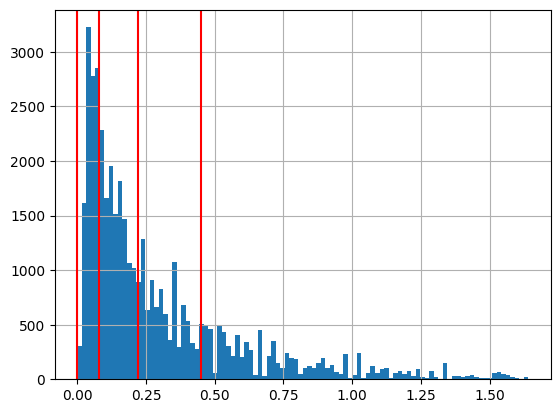

In [ ]:
# make histogram of data
sepsis_vasopressors_cleaned["equiv_gamma"].hist(bins=100)

bins = [0, 0, 0.08, 0.22, 0.45]


print("|Dose Range\t|Mean|Mode|% of Data")
for i, bin in enumerate(bins):
    if i == 0:
        print(f"|[0]|?\t|?\t|?\t")
        continue
    if i == len(bins) - 1:
        bin_vasopressor = sepsis_vasopressors_cleaned[
              sepsis_vasopressors_cleaned["equiv_gamma"] > bin
        ]
        print(f"|>{bin}", end="")
    else:
        bin_vasopressor = sepsis_vasopressors_cleaned[
            (sepsis_vasopressors_cleaned["equiv_gamma"] > bin) & (sepsis_vasopressors_cleaned["equiv_gamma"] <= bins[i+1])
        ]
        print(f"|]{bin}-{bins[i+1]}", end="")
    print(f"|{bin_vasopressor['equiv_gamma'].mean()}|{bin_vasopressor['equiv_gamma'].mode().mean()}|{len(bin_vasopressor)/len(sepsis_vasopressors_cleaned)}")
    plt.axvline(bin, color="red")



## Fluid Intake

In [ ]:
sepsis_fluid = pd.read_gbq(
    f'''
    SELECT m.person_id, m.measurement_concept_id, c.concept_name, measurement_datetime, value_as_number, m.visit_occurrence_id
    FROM measurement as m

    LEFT JOIN concept c ON m.measurement_concept_id = c.concept_id

    WHERE m.visit_occurrence_id IN {tuple(df_train.reset_index()["visit_occurrence_id"].tolist())}
    AND m.provider_id IS NULL
    AND (c.concept_id = 3010494 or c.concept_id = 3037253 or c.concept_id = 3037253 or c.concept_id = 3013308)
    GROUP BY m.person_id, m.measurement_concept_id, c.concept_name, measurement_datetime, value_as_number, m.visit_occurrence_id
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

sepsis_fluid["value_as_number"] = sepsis_fluid["value_as_number"].astype(float)
sepsis_fluid_cleaned = sepsis_fluid[sepsis_fluid["value_as_number"] < sepsis_fluid["value_as_number"].quantile(0.99)]
print(sepsis_fluid.columns)
sepsis_fluid.head()

<ipython-input-11-532e3b0927c2>:1: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  sepsis_fluid = pd.read_gbq(


Index(['person_id', 'measurement_concept_id', 'concept_name',
       'measurement_datetime', 'value_as_number', 'visit_occurrence_id'],
      dtype='object')


,person_id,measurement_concept_id,concept_name,measurement_datetime,value_as_number,visit_occurrence_id
0,17457,3013308,Fluid intake Measured,2013-01-01 05:40:00+00:00,0.0,20225
1,17461,3013308,Fluid intake Measured,2006-01-14 01:57:00+00:00,0.0,20231
2,17461,3013308,Fluid intake Measured,2006-01-18 09:57:00+00:00,0.0,20231
3,19254,3013308,Fluid intake Measured,2006-02-19 09:03:00+00:00,0.0,22283
4,19696,3013308,Fluid intake Measured,2006-01-04 15:50:00+00:00,0.0,22802


<Axes: >

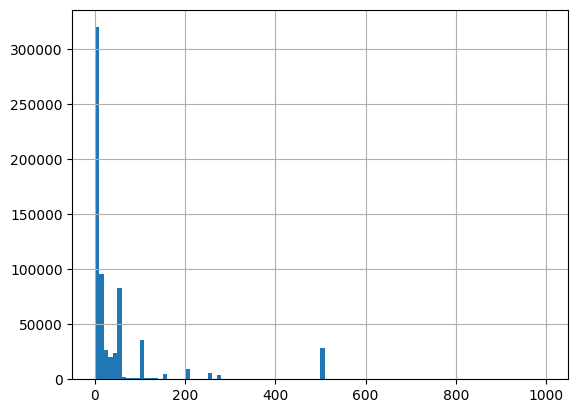

In [ ]:
# make histogram for fluids
fluid_ranges = {
    0, 0, 50, 180, 530
}
sepsis_fluid_cleaned["value_as_number"].hist(bins=100)


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm


def calculate_actions(df_sequences, df_vasopressors):
    # Step 2: Apply the function to df2
    tqdm.pandas()
    gamma_sum = df_sequences.progress_apply(lambda row: compute_window_gamma(row, df_vasopressors), axis=1)

    # Calculate average gamma (handle total_hours = 0 case)
    gamma_sum["average_gamma"] = gamma_sum["total_gamma"] / gamma_sum['total_hours']
    gamma_sum['average_gamma'] = gamma_sum['average_gamma'].fillna(0)  # Fill NaN for empty windows
    return gamma_sum["average_gamma"]


def compute_window_gamma(row, df_vasopressors):
    # Filter intervals from df1 that overlap with the current window
    row["window_end"] = row["measurement_datetime"] + pd.Timedelta(hours=12)
    row["window_start"] = row["measurement_datetime"]

    overlapping = df_vasopressors[
        (df_vasopressors['start_datetime'] < row['window_end']) &\
        (df_vasopressors['stop_datetime'] > row['window_start']) &\
        (df_vasopressors["visit_occurrence_id"] == row["visit_occurrence_id"])
    ]

    if overlapping.empty:
        return pd.Series({'total_gamma': 0, 'total_hours': 0})

    # Calculate overlap duration for normalization
    overlapping['overlap_start'] = overlapping["start_datetime"].apply(lambda x: max(x, row["window_start"]))
    overlapping['overlap_end'] = overlapping["stop_datetime"].apply(lambda x: min(x, row["window_end"]))
    overlapping['overlap_duration'] = (overlapping['overlap_end'] - overlapping['overlap_start']).dt.total_seconds() / 3600  # in hours

    # Compute weighted gamma
    overlapping['weighted_gamma'] = overlapping['equiv_gamma'] * overlapping['overlap_duration']

    # Aggregate results for this window
    total_gamma = overlapping['weighted_gamma'].sum()
    total_hours = overlapping['overlap_duration'].sum()
    return pd.Series({'total_gamma': total_gamma, 'total_hours': total_hours})


gamma_avg = calculate_actions(df_train[["visit_occurrence_id", "measurement_datetime"]], sepsis_vasopressors_cleaned)


100%|██████████| 34796/34796 [02:59<00:00, 193.85it/s]


average_gamma    0.715445
Name: 0.99, dtype: float64


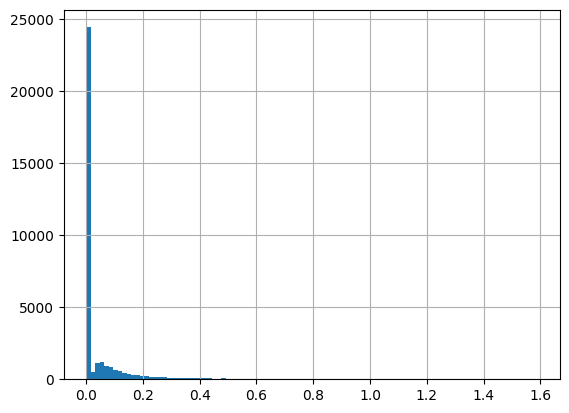

In [ ]:
gamma_avg.hist(bins=100)
print(pd.DataFrame(gamma_avg).quantile(0.99))

In [ ]:
def add_windowed_sum_apply(df_windows, df_values, time_column, value_column, start_col, time_frame, output_col):
    """
    Add a column to `df_windows` with the sum of values in `df_values` that fall within the time windows.

    Parameters:
        df_windows (pd.DataFrame): The DataFrame with time windows.
        df_values (pd.DataFrame): The DataFrame with values and their corresponding timestamps.
        time_column (str): The name of the time column in `df_values`.
        value_column (str): The name of the value column in `df_values`.
        start_col (str): The name of the start time column in `df_windows`.
        end_col (str): The name of the end time column in `df_windows`.
        output_col (str): The name of the column to add to `df_windows` for the sum.

    Returns:
        pd.DataFrame: The `df_windows` DataFrame with the added column.
    """
    # Ensure the time columns are datetime
    df_windows["window_end"] = df_windows[start_col] + pd.Timedelta(hours=time_frame)

    # Define a function to calculate the sum for a single window
    def calculate_sum(row):
        start_time, end_time = row[start_col], row["window_end"]
        return df_values[
            (df_values[time_column] >= start_time) &\
            (df_values[time_column] <= end_time) &\
            (df_values["visit_occurrence_id"] == row["visit_occurrence_id"])
        ][value_column].sum()

    # Apply the function row-wise and create a new column
    df_windows[output_col] = df_windows.progress_apply(calculate_sum, axis=1)

    return df_windows[output_col]

#df_train = df_train.reset_index()
sepsis_fluid_cleaned["measurement_datetime"] = pd.to_datetime(sepsis_fluid_cleaned["measurement_datetime"])
sepsis_fluid_cleaned["value_as_number"] = sepsis_fluid_cleaned["value_as_number"].astype(float)

df_train["fluid_intake"] = add_windowed_sum_apply(
    df_train,
    sepsis_fluid_cleaned,
    "measurement_datetime",
    "value_as_number",
    "measurement_datetime",
    12,
    "fluid_intake_sum"
)


<ipython-input-15-f845480a34f5>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepsis_fluid_cleaned["measurement_datetime"] = pd.to_datetime(sepsis_fluid_cleaned["measurement_datetime"])
<ipython-input-15-f845480a34f5>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepsis_fluid_cleaned["value_as_number"] = sepsis_fluid_cleaned["value_as_number"].astype(float)
100%|██████████| 34796/34796 [05:17<00:00, 109.50it/s]


1089.2051441490023
11745.6000081
2930.40000035


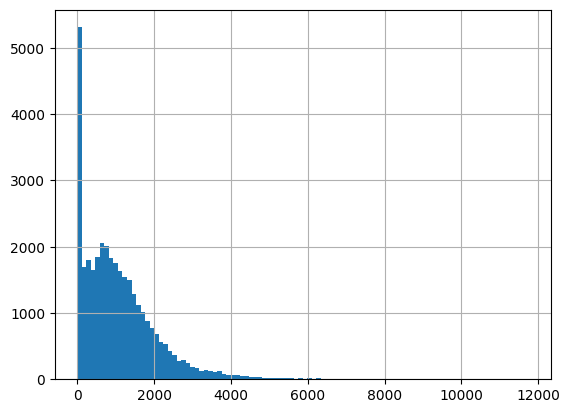

In [ ]:
df_train["fluid_intake_sum"].hist(bins=100)
print(df_train["fluid_intake_sum"].mean())
print(df_train["fluid_intake_sum"].max())
print(df_train["fluid_intake_sum"].quantile(0.95))

# Generate

In [ ]:
import numpy as np

def calculate_states(array1, array2):
    """
    Categorize two NumPy arrays into discrete states and compute unique scores.

    Parameters:
        array1 (numpy.ndarray): The first array.
        array2 (numpy.ndarray): The second array.

    Returns:
        numpy.ndarray: A NumPy array of scores representing unique states (0 to 8).
    """
    # Validate input
    if len(array1) != len(array2):
        raise ValueError("Both arrays must have the same length.")
    median_1 = np.median(array1[array1 != 0])  # median for non 0 values
    median_2 = np.median(array2[array2 != 0])  # median for non 0 values
    # Define categories for array1
    cat1 = np.zeros_like(array1, dtype=int)
    cat1[array1 == 0] = 0
    cat1[(array1 > 0) & (array1 <= median_1)] = 1
    cat1[(array1 > median_1)] = 2

    # Define categories for array2
    cat2 = np.zeros_like(array2, dtype=int)
    cat2[array2 == 0] = 0
    cat2[(array2 > 0) & (array2 <= median_2)] = 1
    cat2[(array2 > median_2)] = 2
    #print(cat2)
    print(median_1)
    print(median_2)

    # Compute unique scores based on the combination of categories
    # Scores are computed as: cat1 * 3 + cat2
    scores = cat1 * 3 + cat2
    print("Fluids", np.unique(cat1, return_counts=True))
    print("VPs", np.unique(cat2, return_counts=True))

    return scores
df_train["action"] = calculate_states(df_train["fluid_intake_sum"].values, gamma_avg.values)
print(df_train["action"].unique())

1031.5
0.10851449377616747
Fluids (array([0, 1, 2]), array([ 4357, 15220, 15219]))
VPs (array([0, 1, 2]), array([24381,  5208,  5207]))
[0 8 6 7 3 5 4 2 1]


[0 8 6 7 3 5 4 2 1]


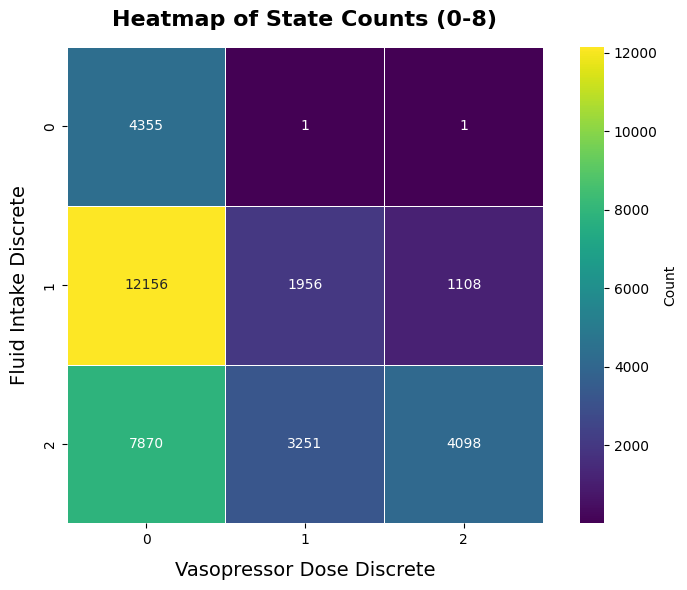

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_heatmap(scores):
    """
    Plot a 3x3 heatmap where each cell is colored by the count of scores (0-8).

    Parameters:
        scores (numpy.ndarray): Array of scores in the range [0, 8].

    Returns:
        None
    """
    # Ensure scores are within the valid range [0, 8]
    if not np.all((0 <= scores) & (scores <= 8)):
        raise ValueError("Scores must be in the range [0, 8].")

    # Count occurrences for each score
    counts = np.bincount(scores, minlength=9)

    # Reshape counts into a 3x3 matrix
    heatmap_matrix = counts.reshape(3, 3)

    # Create the heatmap using Seaborn
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        heatmap_matrix,
        annot=True,                # Annotate with count values
        fmt="d",                   # Integer format for annotations
        cmap="viridis",            # Color map
        cbar_kws={"label": "Count"},  # Colorbar label
        linewidths=0.5,            # Add gridlines for clarity
        linecolor="white",         # Gridline color
        square=True                # Ensure square cells
    )

    # Add labels and title
    ax.set_title("Heatmap of State Counts (0-8)", fontsize=16, fontweight="bold", pad=15)
    ax.set_xlabel("Vasopressor Dose Discrete", fontsize=14, labelpad=10)
    ax.set_ylabel("Fluid Intake Discrete", fontsize=14, labelpad=10)
    ax.set_xticks([0.5, 1.5, 2.5], ["0", "1", "2"])
    ax.set_yticks([0.5, 1.5, 2.5], ["0", "1", "2"])

    # Adjust plot layout
    plt.tight_layout()
    plt.show()

# Example usage
print(df_train["action"].unique())
plot_heatmap(df_train["action"].values)


# Outcome Data - In hospital Mortality

<ipython-input-19-5222d202262f>:2: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  sepsis_death = pd.read_gbq(


9794 persons died of sepsis in the hospital
25002 persons survived ICU


<Axes: >

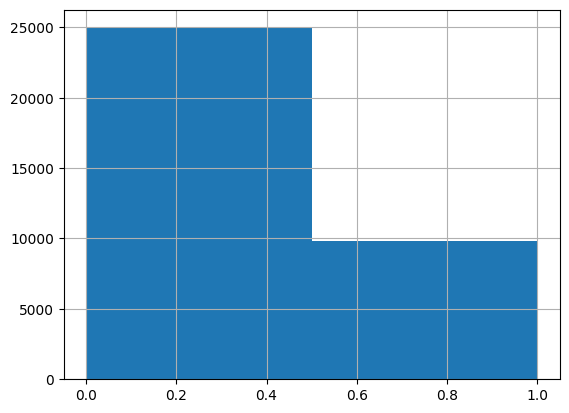

In [ ]:
#df_train = df_train.reset_index()
sepsis_death = pd.read_gbq(
    f'''
    SELECT
        vo.person_id,
        vo.visit_occurrence_id,
        d.death_datetime,
        vo.visit_start_datetime,
        vo.visit_end_datetime,
        ABS(TIMESTAMP_DIFF(vo.visit_start_datetime, d.death_datetime, DAY)) AS in_hospital_survived
    from visit_occurrence AS vo
    LEFT JOIN death AS d
        ON vo.person_id = d.person_id
    WHERE vo.visit_occurrence_id IN {tuple(df_train["visit_occurrence_id"].tolist())}
    GROUP BY vo.person_id, vo.visit_occurrence_id, d.death_datetime, vo.visit_start_datetime, vo.visit_end_datetime
    '''
    , configuration=config_gbq, use_bqstorage_api=True)
# Ensure the columns are datetime objects
sepsis_death['death_datetime'] = pd.to_datetime(sepsis_death['death_datetime'])
sepsis_death['visit_end_datetime'] = pd.to_datetime(sepsis_death['visit_end_datetime'])
sepsis_death['visit_start_datetime'] = pd.to_datetime(sepsis_death['visit_start_datetime'])

# Set 'in_hospital_survived' to NaN where death_datetime is after visit_end_datetime
sepsis_death.loc[:,'died_in_hospital'] = 0
sepsis_death.loc[
    (sepsis_death['death_datetime'] <= sepsis_death['visit_end_datetime']) &\
    (sepsis_death['death_datetime'] >= sepsis_death['visit_start_datetime']),
    'died_in_hospital'
] = 1
sepsis_death['died_in_hospital'] = sepsis_death['died_in_hospital'].fillna(0).astype(int)

sepsis_death_filtered = sepsis_death.merge(
    df_train[["visit_occurrence_id"]],
    on="visit_occurrence_id",
    how="inner"
)
print((sepsis_death_filtered["died_in_hospital"]==1).sum(), "persons died of sepsis in the hospital")
print((sepsis_death_filtered["died_in_hospital"]==0).sum(), "persons survived ICU")

sepsis_death_filtered["died_in_hospital"].hist(bins=2)


<ipython-input-20-7ddc868a9ec8>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


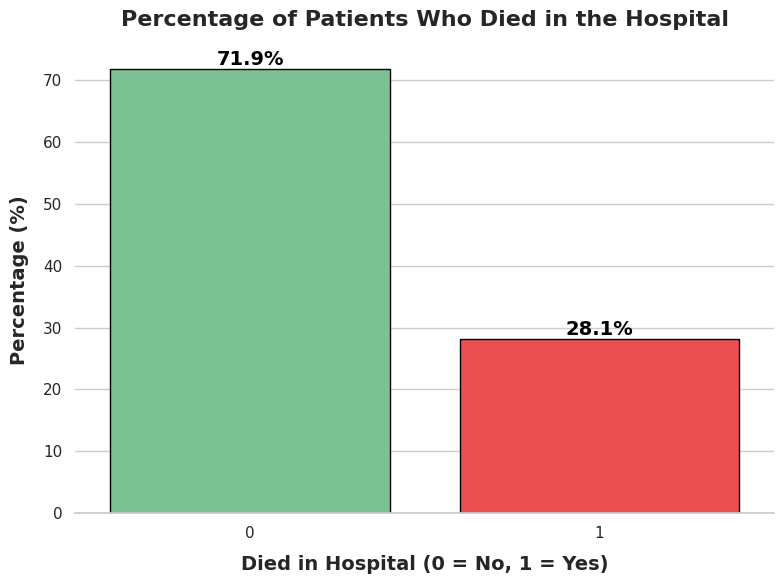

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the percentage distribution
counts = sepsis_death_filtered["died_in_hospital"].value_counts(normalize=True) * 100

# Create a DataFrame for seaborn
plot_data = counts.reset_index()
plot_data.columns = ["Died in Hospital", "Percentage"]

# Create the Seaborn barplot
sns.set_theme(style="whitegrid")  # Set Seaborn theme
fig, ax = plt.subplots(figsize=(8, 6))
palette = ["#76c893", "#f94144"]  # Custom colors for 'No' and 'Yes'

sns.barplot(
    x="Died in Hospital", y="Percentage", data=plot_data,
    palette=palette, ax=ax, saturation=0.85, edgecolor="black"
)

# Customize the plot
ax.set_title("Percentage of Patients Who Died in the Hospital", fontsize=16, fontweight="bold", pad=15)
ax.set_xlabel("Died in Hospital (0 = No, 1 = Yes)", fontsize=14, fontweight="bold", labelpad=10)
ax.set_ylabel("Percentage (%)", fontsize=14, fontweight="bold", labelpad=10)

# Annotate the bars with percentages
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom", fontsize=14, fontweight="bold", color="black")

# Remove unnecessary spines
sns.despine(left=True, bottom=False)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Making the binary in-hospital death
df_train = df_train.merge(
    sepsis_death_filtered[["visit_occurrence_id", "died_in_hospital"]],
    on="visit_occurrence_id",
    how="left",
    suffixes=("", "_new")
)
print(df_train["died_in_hospital"].unique())
df_train["died_in_hospital"] = df_train["died_in_hospital"].fillna(0).astype(int)

[1 0]


         visit_occurrence_id  seq_id  died_in_hospital
0                         11       1                 1
1                         11       2                 1
2                         11       3                 1
3                         11       4                 1
4                         11       5                 1
...                      ...     ...               ...
2679811                23540      32                 0
2679812                23540      33                 0
2679813                23540      34                 0
2679814                23540      35                 0
2679815                23540      36                 0

[2679816 rows x 3 columns]
[   0 -100  100]


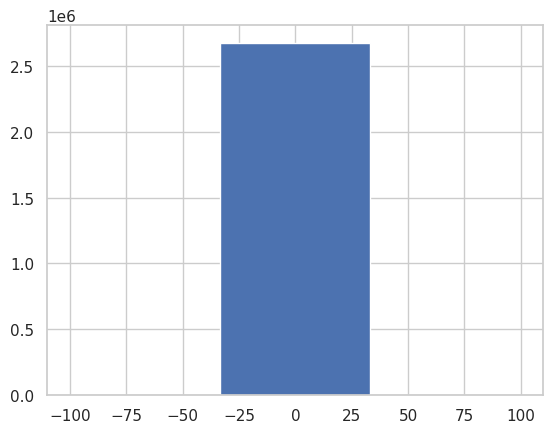

In [ ]:
df_train["reward"] = 0
df_train = df_train.sort_values(by=["visit_occurrence_id", "measurement_datetime"])
# Add sequence_id within each visit_occurrence_id
df_train["seq_id"] = df_train.groupby("visit_occurrence_id").cumcount() + 1
# Find the row index for the maximum sequence_id for each visit_occurrence_id
max_sequence_indices = df_train.groupby("visit_occurrence_id")["seq_id"].idxmax()
print(df_train[["visit_occurrence_id", "seq_id", "died_in_hospital"]])

# Set reward to 100 or -100 based on died_in_hospital flag
df_train.loc[max_sequence_indices, "reward"] = df_train.loc[max_sequence_indices, "died_in_hospital"].apply(
    lambda x: 100 if x == 0.0 else -100
)

df_train["reward"].hist(bins=3)
print(df_train["reward"].unique())

# Obtaining States

In [ ]:
# Clustering
from src.clustering import cluster_kmpp
# chose numeric columns
print(df_train.columns)
df_train_clust = df_train[[
    'gender_source_value', 'year_of_birth', 'Alanine aminotransferase',
    'Albumin', 'Aspartate aminotransferase', 'Base excess', 'Bicarbonate',
    'Bilirubin.total', 'Calcium', 'Calcium.ionized',
    'Chloride', 'Creatinine', 'Diastolic blood pressure', 'FiO2', 'Glucose',
    'Hemoglobin', 'INR', 'Lactate', 'Leukocytes', 'Magnesium',
    'Mean Blood Pressure', 'PaOxygen', 'Platelets', 'Potassium',
    'Respiratory rate', 'Sodium', 'SpO2', 'Systolic Blood Pressure', 'Urea',
    'Urine', 'Weight', 'aPTT', 'pH Blood', 'ventilatory_support',
    'pao2_fio2_ratio', 'pao2']]

kmeans, cluster_centers = cluster_kmpp(df_train_clust, k=200)
df_train["state"] = kmeans.predict(df_train_clust)

Index(['visit_occurrence_id', 'measurement_datetime', 'index',
       'gender_source_value', 'year_of_birth', 'Alanine aminotransferase',
       'Albumin', 'Aspartate aminotransferase', 'Base excess', 'Bicarbonate',
       'Bilirubin.total', 'Calcium', 'Calcium.ionized', 'Chloride',
       'Creatinine', 'Diastolic blood pressure', 'FiO2', 'Glucose',
       'Hemoglobin', 'INR', 'Lactate', 'Leukocytes', 'Magnesium',
       'Mean Blood Pressure', 'PaOxygen', 'Platelets', 'Potassium',
       'Respiratory rate', 'Sodium', 'SpO2', 'Systolic Blood Pressure', 'Urea',
       'Urine', 'Weight', 'aPTT', 'pH Blood', 'paCO2', 'ventilatory_support',
       'pao2_fio2_ratio', 'pao2', 'seq_id', 'window_end', 'fluid_intake_sum',
       'fluid_intake', 'action', 'died_in_hospital', 'reward'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [ ]:
df_train.describe()

,visit_occurrence_id,index,gender_source_value,year_of_birth,Alanine aminotransferase,Albumin,Aspartate aminotransferase,Base excess,Bicarbonate,Bilirubin.total,...,ventilatory_support,pao2_fio2_ratio,pao2,seq_id,fluid_intake_sum,fluid_intake,action,died_in_hospital,reward,state
count,2679816.0,2.679816e+06,2.679816e+06,2679816.0,2.679816e+06,2.679816e+06,2.679816e+06,2.679816e+06,2.679816e+06,2.679816e+06,...,2679816.0,2.679816e+06,2.679816e+06,2.679816e+06,2.679816e+06,2.679816e+06,2.679816e+06,2.679816e+06,2.679816e+06,2.679816e+06
mean,11532.36179,-5.327940e-03,1.190922e-01,-0.169818,1.991913e-02,-5.990542e-02,-1.253288e-01,1.960547e-01,2.431103e-01,-1.426624e-02,...,-0.024198,-5.984141e-02,-4.381186e-02,1.531576e+04,1.023956e+03,1.023956e+03,4.413397e+00,3.871631e-01,2.414345e-02,9.583084e+01
std,6422.270303,9.655505e-01,9.579275e-01,0.947868,9.433168e-01,9.188650e-01,9.112331e-01,9.553581e-01,9.683305e-01,1.012709e+00,...,0.975825,8.377380e-01,1.027557e+00,3.032421e+04,8.726124e+02,8.726124e+02,2.207029e+00,4.871016e-01,2.043301e+00,5.749208e+01
min,11.0,-1.732018e+00,-1.263037e+00,-1.704481,-3.703759e+00,-3.230001e+00,-3.469364e+00,-2.582369e+00,-2.842582e+00,-3.296733e+00,...,-1.544247,-1.614981e+00,-5.885571e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+02,0.000000e+00
25%,6476.0,-7.593807e-01,-1.263037e+00,-1.029876,-6.634438e-01,-6.881562e-01,-7.932350e-01,-4.042477e-01,-3.826325e-01,-7.354734e-01,...,-1.201541,-6.740524e-01,-2.109178e-01,1.447000e+03,3.985000e+02,3.985000e+02,3.000000e+00,0.000000e+00,0.000000e+00,4.500000e+01
50%,11516.0,-5.521304e-02,7.917301e-01,-0.35527,4.111749e-02,-3.699822e-02,-1.821436e-01,2.156270e-01,2.329893e-01,-7.946001e-02,...,0.699563,-1.261317e-01,-2.363272e-02,4.689000e+03,8.560000e+02,8.560000e+02,4.000000e+00,0.000000e+00,0.000000e+00,9.300000e+01
75%,16206.0,6.951359e-01,7.917301e-01,0.319335,7.051234e-01,5.529108e-01,5.253383e-01,8.318887e-01,8.761308e-01,7.399393e-01,...,0.699563,5.310822e-01,2.980060e-01,1.252800e+04,1.424800e+03,1.424800e+03,6.000000e+00,1.000000e+00,0.000000e+00,1.460000e+02
max,23540.0,1.731975e+00,7.917301e-01,2.478073,2.104307e+00,2.350946e+00,2.129468e+00,3.062129e+00,2.845593e+00,2.073865e+00,...,0.699563,2.170700e+00,3.458057e+01,1.831840e+05,1.174560e+04,1.174560e+04,8.000000e+00,1.000000e+00,1.000000e+02,1.990000e+02


<ipython-input-25-7953ad875762>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap("tab10", len(unique_clusters))


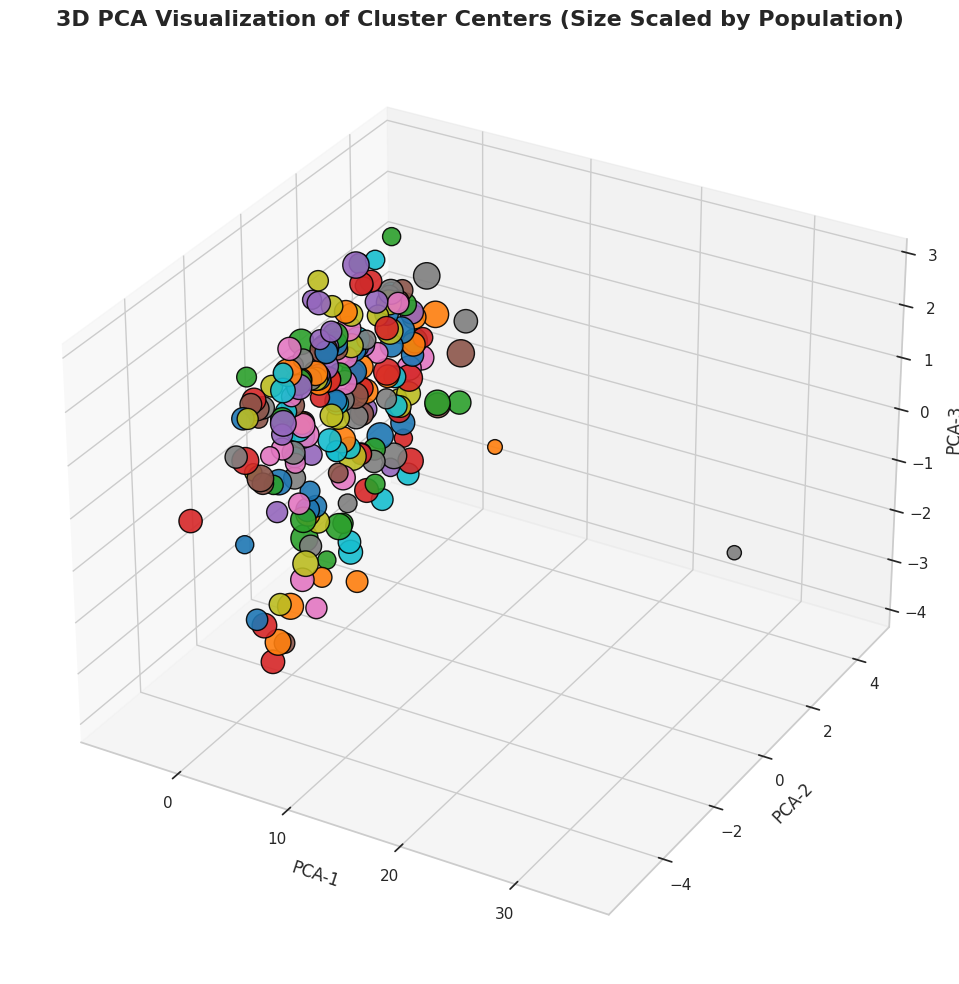

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample data (replace with your clustered data)
data = df_train_clust.copy().values  # Replace with your data
cluster_labels = df_train["state"].values  # Replace with your cluster labels

# Calculate cluster centers and sizes
unique_clusters = np.unique(cluster_labels)
cluster_centers = np.array([data[cluster_labels == cluster].mean(axis=0) for cluster in unique_clusters])
cluster_sizes = np.array([np.sum(cluster_labels == cluster) for cluster in unique_clusters])  # Cluster population

# Apply PCA to reduce cluster centers to 3D
pca = PCA(n_components=3)
pca_results = pca.fit_transform(cluster_centers)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(pca_results, columns=["PCA-1", "PCA-2", "PCA-3"])
pca_df["Cluster"] = unique_clusters
pca_df["Size"] = cluster_sizes

# Generate a color palette for distinct colors
color_palette = plt.cm.get_cmap("tab10", len(unique_clusters))
colors = [color_palette(cluster) for cluster in unique_clusters]

# Normalize cluster sizes for plotting
marker_sizes = (pca_df["Size"] / pca_df["Size"].max()) * 300 + 100  # Scale marker sizes

# 3D Plot using Matplotlib
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for cluster centers
scatter = ax.scatter(
    pca_df["PCA-1"], pca_df["PCA-2"], pca_df["PCA-3"],
    c=colors, s=marker_sizes, alpha=0.9, edgecolor="black"
)

# Add labels and title
ax.set_title("3D PCA Visualization of Cluster Centers (Size Scaled by Population)", fontsize=16, fontweight="bold")
ax.set_xlabel("PCA-1", fontsize=12)
ax.set_ylabel("PCA-2", fontsize=12)
ax.set_zlabel("PCA-3", fontsize=12)

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
del data

In [ ]:
df_train[["state", "action", "reward", "seq_id"]].head()

,state,action,reward,seq_id
0,117,0,0,1
1,117,0,0,2
2,117,0,0,3
3,117,0,0,4
4,117,8,0,5


# Transform df for training

In [ ]:
import pandas as pd

# Example DataFrame
df_train_rl = df_train[['state','action','reward','seq_id','visit_occurrence_id']]

# Initialize an empty list to store trajectory data
trajectory_data = []

# Group by 'id' to handle each trajectory independently
for _, group in df_train_rl.groupby('visit_occurrence_id'):
    group = group.sort_values('seq_id')  # Ensure the sequence is sorted
    states = group['state'].tolist()
    actions = group['action'].tolist()
    rewards = group['reward'].tolist()

    # Create next_state by shifting 'state' column
    next_states = states[1:] + [None]  # Last next_state is None

    # Create done flag (1 for the last step, 0 otherwise)
    done_flags = [0] * (len(states) - 1) + [1]

    # Build the trajectory data
    for i in range(len(states)):
        trajectory_data.append({
            'state': states[i],
            'action': actions[i],
            'reward': rewards[i],
            'next_state': next_states[i],
            'done': done_flags[i]
        })

# Convert trajectory data to a DataFrame
trajectory_data = pd.DataFrame(trajectory_data)

# Display the result
print(trajectory_data)


         state  action  reward  next_state  done
0          117       0       0       117.0     0
1          117       0       0       117.0     0
2          117       0       0       117.0     0
3          117       0       0       117.0     0
4          117       8       0       117.0     0
...        ...     ...     ...         ...   ...
2679811    119       7       0       119.0     0
2679812    119       7       0       119.0     0
2679813    119       7       0       119.0     0
2679814    119       7       0       119.0     0
2679815    119       7     100         NaN     1

[2679816 rows x 5 columns]


In [30]:
import numpy as np
import pandas as pd

class QLearningAgent:
    def __init__(self, num_states, num_actions, learning_rate=0.5, discount_factor=0.9, exploration_rate=0.1):
        self.num_states = num_states
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.q_table = np.zeros((num_states, num_actions))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.exploration_rate:
            return np.random.choice(self.num_actions)  # Explore: choose a random action
        else:
            return np.argmax(self.q_table[state, :])  # Exploit: choose the action with the highest Q-value

    def learn(self, state, action, reward, next_state, done):
        if next_state is not None and not np.isnan(next_state): # Check for None and NaN
            best_next_action = np.argmax(self.q_table[int(next_state), :])
            td_target = reward + self.discount_factor * self.q_table[int(next_state), best_next_action]
        else:
            td_target = reward  # No next state, so only consider the immediate reward
        td_error = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.learning_rate * td_error

# Initialize the agent
num_states = df_train["state"].max() + 1  # Get number of states from your data
num_actions = 9  # Assuming 9 actions (0-8) from your 'action' column
agent = QLearningAgent(num_states, num_actions)

# Training loop using vectorized operations
num_epochs = 100
batch_size = 32  # You can adjust this

for epoch in range(num_epochs):
    # Shuffle the trajectory data
    trajectory_data = trajectory_data.sample(frac=1).reset_index(drop=True)

    for i in range(0, len(trajectory_data), batch_size):
        batch = trajectory_data.iloc[i : i + batch_size]

        states = batch['state'].to_numpy(dtype=int)
        actions = batch['action'].to_numpy(dtype=int)
        rewards = batch['reward'].to_numpy(dtype=float)
        next_states = batch['next_state'].to_numpy()
        done_flags = batch['done'].to_numpy(dtype=bool)

        # Convert next_states to valid indices and identify terminal states
        next_states_int = np.nan_to_num(next_states, nan=-1).astype(int)
        valid_next_states_mask = next_states_int != -1

        # Compute TD targets
        td_targets = np.zeros_like(rewards, dtype=float)
        td_targets[valid_next_states_mask] = (
            rewards[valid_next_states_mask]
            + agent.discount_factor
            * np.max(agent.q_table[next_states_int[valid_next_states_mask], :], axis=1)
        )
        td_targets[~valid_next_states_mask] = rewards[~valid_next_states_mask]  # Terminal states

        # Compute TD errors and update Q-values
        td_errors = td_targets - agent.q_table[states, actions]
        agent.q_table[states, actions] += agent.learning_rate * td_errors

# Access the learned Q-table: agent.q_table
agent.q_table

KeyboardInterrupt: 